<h1><center>Drawing Conclusions using Faculty Course Evaluations (FCE) and other Data</center></h1>

At the end of every semester, Carnegie Mellon University asks its students to complete Faculty Course Evaulations (FCEs). These evaluations gives the students the opportunity to rate the course and the professor by providing ratings (on a scale of 1 through 5) on various criterias such as 'Interest in Student Learning' and 'Demonstrate Importance of Subject Matter'. While many students merely use the FCE data to check how much hours one should commit to the class, this Jupyter Notebook will explore what other interesting questions we can ask using this data. Using the FCE data and other data gathered, we will be exploring the following questions:

* Does Professor Title Have Anything to do FCE Ratings?
* How accurate are RateMyProfessor reviews compared to the FCE data? 
* Are Courses Offered in the Summer Better than those Offered in the Year?

## Getting Started
We will first start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

## Cleaning the FCE data
Let us first observe what our data looks like.

In [2]:
df = pd.read_csv("fce.csv")
df.head()

,Year,Semester,College,Dept,Course ID,Section,Name,Course Name,Level,Possible Respondents,...,Hrs Per Week 8,Interest in student learning,Clearly explain course requirements,Clear learning objectives & goals,Instructor provides feedback to students to improve,Demonstrate importance of subject matter,Explains subject matter of course,Show respect for all students,Overall teaching rate,Overall course rate
0,2019,Fall,College of Fine Arts,ARC,48358,B1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,26,...,NaN,4.79,4.62,4.57,4.69,4.57,4.71,4.93,4.71,4.71
1,2019,Fall,College of Fine Arts,ARC,48358,A1,"BEN-ALON, RACHEL",EARTHEN BUILDING,Undergraduate,8,...,NaN,5.00,5.00,4.83,4.83,5.00,4.83,5.00,4.33,4.17
2,2019,Fall,College of Fine Arts,ARC,48689,A1,"KIM, MAN",DIGI SKLLS WRKSHP,Graduate,14,...,NaN,4.75,4.63,4.75,4.88,4.50,4.75,4.63,4.75,4.38
3,2019,Fall,College of Fine Arts,ARC,48753,A1,"DAWKINS, MARANTHA",INTRO UD MED,Graduate,14,...,NaN,4.00,3.00,3.60,4.40,3.60,3.40,4.60,3.60,3.20
4,2019,Fall,College of Fine Arts,ART,60131,A1,"GURYSH, STEVEN",3D MEDIA STUDIO I,Undergraduate,11,...,NaN,4.88,4.63,4.86,4.86,4.57,4.86,5.00,4.86,4.71


In [3]:
print(df.isna().sum())

Year                                                       0
Semester                                                   0
College                                                    0
Dept                                                       0
Course ID                                                  0
Section                                                    0
Name                                                       1
Course Name                                                0
Level                                                      0
Possible Respondents                                       0
Num Respondents                                            0
Response Rate %                                            0
Hrs Per Week                                           20635
Hrs Per Week 5                                         37504
Hrs Per Week 8                                         42744
Interest in student learning                            1661
Clearly explain course r

Let us clean our data to make it easier to process. There seems to a row where "Name" has a value of NaN. We will drop this row.

In [4]:
df = df[pd.notnull(df['Name'])]  # Dropping all rows with column 'Name' = NaN 

There seems to be a lot of NaN values for columns 'Hrs Per Week 5' and 'Hrs Per Week 8', so we will drop those columns. For the remaining columns with NaN values, we will replace those values with the mean of their respective column

In [5]:
df = df[df["College"] != "Teaching Assistants"]
if "Hrs Per Week 5" in df.columns and "Hrs Per Week 8" in df.columns:
    df = df.drop(columns=["Hrs Per Week 5", "Hrs Per Week 8"])

Let us verify we do not have any more NaN values.

In [6]:
lst = df.columns[df.isnull().any()].tolist()
df[lst] = df[lst].fillna(df[lst].mean())
print(df.isna().sum())

Year                                                   0
Semester                                               0
College                                                0
Dept                                                   0
Course ID                                              0
Section                                                0
Name                                                   0
Course Name                                            0
Level                                                  0
Possible Respondents                                   0
Num Respondents                                        0
Response Rate %                                        0
Hrs Per Week                                           0
Interest in student learning                           0
Clearly explain course requirements                    0
Clear learning objectives & goals                      0
Instructor provides feedback to students to improve    0
Demonstrate importance of subje

Now that we have cleaned up the FCE data, let us use this to ask questions about Carnegie Mellon Courses and Faculty.

## Average FCE Hours By Department
We are curious about the average FCE hours by department. Let us create a visualization to see which department tends to have the highest FCE hours.

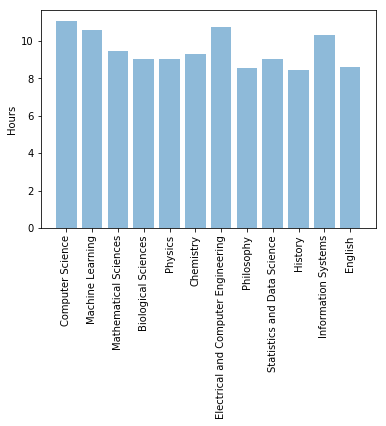

In [7]:
df_grad = df[df['Level'] == "Graduate"]
df_undergrad = df[df['Level'] == "Undergraduate"]

department_id = {############SCS###############
                "Computer Science": "15",
                "Machine Learning": "10",
                 ############MCS###############
                 "Mathematical Sciences": "21",
                 "Biological Sciences": "03",
                 "Physics": "03",
                 "Chemistry": "05",
                 ############CIT###############
                 "Electrical and Computer Engineering": "18",
                 ############DC################
                 "Philosophy": "80",
                 "Statistics and Data Science": "36",
                 "History": "79",
                 "Information Systems": "67",
                 "English": "76"}

id_list = []
hour_list = []

for ids in department_id:
    id_list.append(ids)
    hour_list.append(df_undergrad[df_undergrad["Course ID"].str.startswith(department_id[ids])]["Hrs Per Week"].mean())

pos = [hour[0] for hour in enumerate(hour_list)]
    
plt.bar(pos, hour_list, align='center', alpha=0.5)
plt.xticks(pos, id_list)
plt.xticks(rotation=90)
plt.ylabel('Hours')

plt.show()

## MCS Faculty: Teaching vs. Tenure Professors


In [8]:
def process_name(s):
    name_str = s.upper()
    name = name_str.split(" ")
    return name[1] + ", " + name[0]

#(list of teaching ratings, list of tenure ratings)
def getTeachingVsTenure(mcs_faculty, department):
    mcs = mcs_faculty[mcs_faculty["Department"] == department]
    mcs_teaching = mcs[mcs['Title'].str.contains("Teaching", na=False)]
    mcs_tenure_temp = mcs[~mcs['Title'].str.contains("Teaching", na=False)]
    mcs_tenure = mcs_tenure_temp[mcs_tenure_temp['Title'].str.contains("Professor", na=False)]
    teaching_faculty = {}
    tenure_faculty = {}

    for x in mcs_teaching["Name"]:
        person = df[df["Name"] == x]
        rating = person["Overall course rate"].mean()
        if not math.isnan(rating): teaching_faculty[x] = rating

    for x in mcs_tenure["Name"]:
        person = df[df["Name"] == x]
        rating = person["Overall course rate"].mean()
        if not math.isnan(rating): tenure_faculty[x] = rating
    
    teachingList = [teaching_faculty[x] for x in teaching_faculty]
    tenureList = [tenure_faculty[x] for x in tenure_faculty]
    return teachingList, tenureList

mcs_faculty = pd.read_csv("mcs_faculty.csv")
mcs_faculty['Name'] = mcs_faculty['Name'].apply(process_name)

departments = ["Mathematical Sciences", "Physics", "Chemistry", "Biological Sciences"]

for d in departments:
    teaching, tenure = getTeachingVsTenure(mcs_faculty, d)
    print(d, sum(teaching)/len(teaching), sum(tenure)/len(tenure))

Mathematical Sciences 4.140443585973592 4.38673073484636
Physics 4.407427317731773 4.033054088825235
Chemistry 3.934956415468609 4.103659547987251
Biological Sciences 4.29930238791423 4.155974640594837


## Are Summer Courses Better than Year Courses?

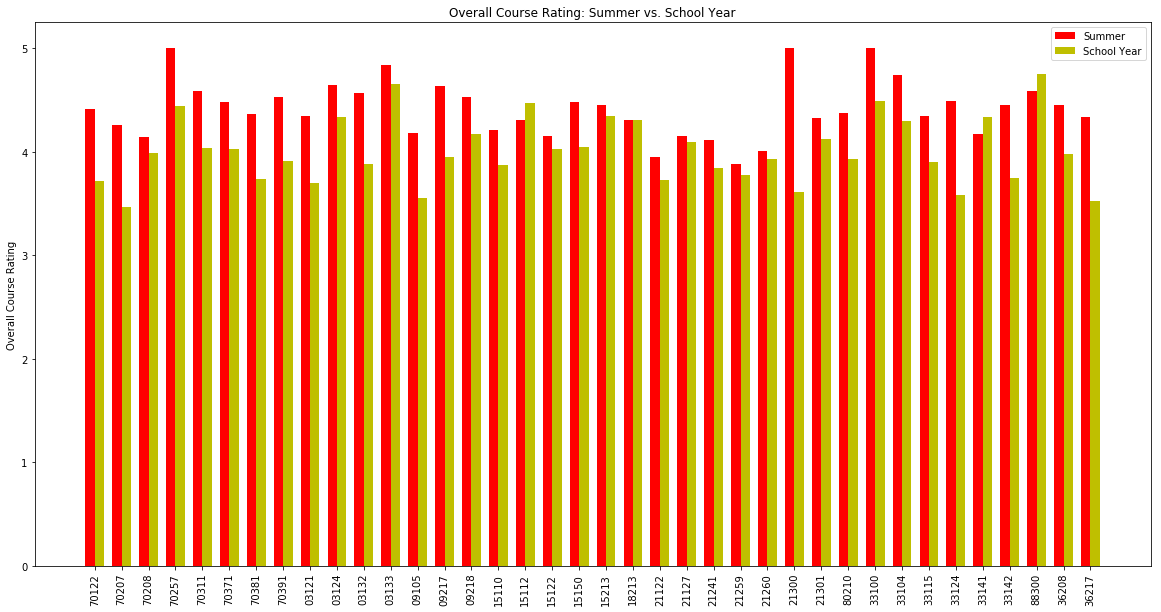

In [9]:
df_summer = df[df['Semester'] == "Summer"]
df_year = df[df['Semester'] != "Summer"]

courses = open("summer_courses_id.txt", "r").read().split()

summer_rate = []
year_rate = []

for cls in courses:
    summer_rate.append(df_summer[df_summer['Course ID'] == cls]["Overall course rate"].mean())
    year_rate.append(df_year[df_year['Course ID'] == cls]["Overall course rate"].mean())

N = len(courses)
summer = summer_rate

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
bar1 = ax.bar(ind, summer, width, color='r')

year = year_rate
bar2 = ax.bar(ind + width, year, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Overall Course Rating')
ax.set_title("Overall Course Rating: Summer vs. School Year")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(courses)
plt.xticks(rotation=90)

ax.legend((bar1[0], bar2[0]), ('Summer', 'School Year'))

plt.show()

In [10]:
df_grad = df[df['Level'] == "Graduate"]
df_undergrad = df[df['Level'] == "Undergraduate"]
print("Number of data points for graduate is", len(df_grad),"\n")
print("Number of data points for undergraduate is", len(df_undergrad))

Number of data points for graduate is 20070 

Number of data points for undergraduate is 29465


In [11]:
avg_grad_fce = df_grad.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = df_undergrad.groupby(["Year", "College"], as_index=False).mean()

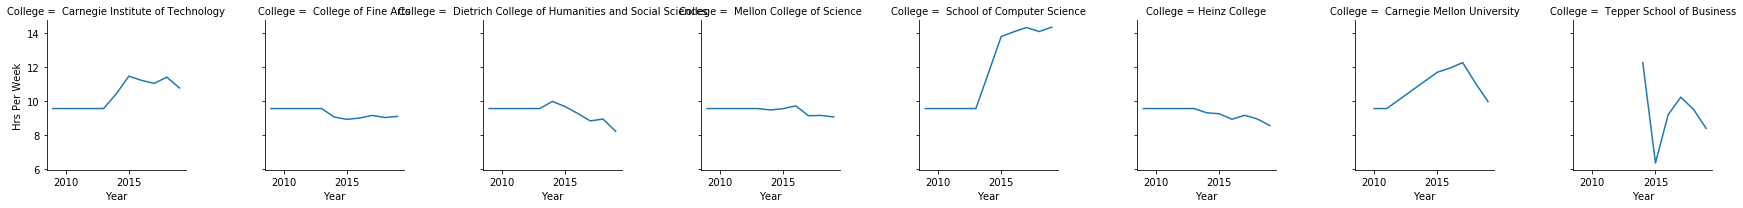

In [12]:
avg_grad_fce = avg_grad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_grad_fce = avg_grad_fce[["Year", "College","Hrs Per Week"]]

g = sns.FacetGrid(avg_grad_fce, col="College")
g.map(plt.plot,"Year", "Hrs Per Week")
g.add_legend()

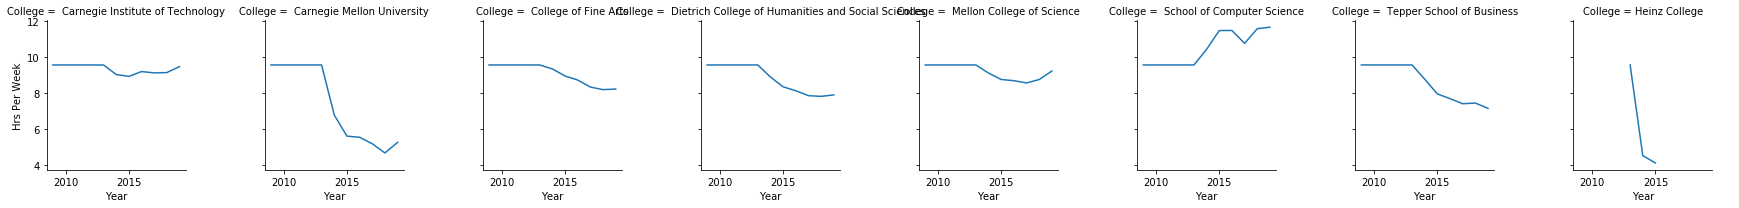

In [13]:
avg_undergrad_fce = avg_undergrad_fce.groupby(["Year", "College"], as_index=False).mean()
avg_undergrad_fce = avg_undergrad_fce[["Year", "College","Hrs Per Week"]]

g = sns.FacetGrid(avg_undergrad_fce, col="College")
g.map(plt.plot,"Year", "Hrs Per Week")
g.add_legend()

We can find some interesting results based on the graphs above. 
* For graduates at CMU, the FCE seem to be having an increasing trend over the years, peaking around 2017, and then gradually decrease till now. Whereas for the undergrads at CMU, the FCE seem to be decreasing, with a slight increase at 2019. 
* The **School of Computer Science** has the **greatest increase**, with an approximately 5 hours of increase from 2013 to 2019 for the graduates(9hr -> 14hr), and approximately 3 hours of increase from (9hr -> 12hr). Some possible explanation for this might be:
    * CS classes are getting harder and students need to spend more time on them.
    * More people outside SCS might be interested in CS, and they might tend to spend more time on CS classes than CS majors. <br>
    
Cite: this dataset is also used in CMU Data Science Club's Challenges, so this part (FCE by college) might appear similar. <br>
Now let's do some analysis on the **correlation of the columns**.

In [14]:
# sns.palplot(sns.color_palette("BrBG", 10))
plt.figure(figsize = (20,20))
corr_lst = list(df.select_dtypes(include=['int', 'float']).columns)
corr_df = df[corr_lst]
corr_df.drop("Year", axis=1, inplace=True)
corr = corr_df.corr()
sns.set(font_scale=1.5)
ax = sns.heatmap(corr, cmap=sns.diverging_palette(220, 20, as_cmap=True),
                 annot=True, annot_kws={"size": 20})

KeyError: "['Year'] not found in axis"

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print(ttest_ind(df['Overall teaching rate'], df["Overall course rate"]))
print(ttest_ind(df['Explains subject matter of course'], df["Overall course rate"]))

It seems that the `overall teaching rate` is highly correlated with `overall course rate` and `Explains subject matter of course`. <br>
So we calculate the statistic significance, both of the p-values are < 0.05, so they're statistically significant.

### Potentially fit a model for Overall Teaching Rate here?

Now that we have found this interesting pattern for SCS department, we want to ask, does courses in SCS get **higher course rating** with **higher levels**? <br>
i.e. Does a class like 15-4XX get higher rating than 15-1XX class in general?

### Question: Does SCS course get higher course rating with higher levels?

In [ ]:
df_dept = df.copy()
def f(x):
    # There are different course listing in the past
    # such as "FA14-12-100" for CIT
    # so here we preprocess these data and create a column for the course ID level
    if x.startswith("F"):
        lst = x.split("-")
        x = lst[-2]+lst[-1]
    x = x[-3:]
    x = int(x)//100
    return (x)
df_dept["Course ID Level"] = df_dept["Course ID"].apply(f)

In [ ]:
df_dept_plot = df_dept.groupby(["College", "Dept", "Course ID Level"], as_index=False).mean()
df_dept_plot_selected = df_dept_plot[["College", "Dept", "Course ID Level", "Overall course rate"]]
df_dept_plot_selected["College"].unique()

In [ ]:
df_dept_plot_SCS = df_dept_plot_selected.loc[df_dept_plot_selected["College"] == " School of Computer Science"]
min_ID = df_dept_plot_SCS["Course ID Level"].min()
max_ID = df_dept_plot_SCS["Course ID Level"].max()
print("For SCS,","min_ID =", min_ID, "max_ID=", max_ID)

In [ ]:
df_dept_plot_SCS[df_dept_plot_SCS["Dept"]=="SCS"].head()
# The "SCS" department seems buggy - it only has one course ID level
# Let's drop it.

In [ ]:
df_dept_plot_SCS = df_dept_plot_SCS[df_dept_plot_SCS["Dept"] !="SCS"]

In [ ]:
# df_dept_plot_CIT.plot(x="Dept", y="Overall course rate", kind="scatter")
plt_size = 10
fig, ax = plt.subplots(figsize=(2*plt_size,plt_size))
fig.suptitle('SCS Dept courses rating by level (color represents level)')
ax.set_ylabel("Overall course rate", fontsize=2*plt_size)
ax.set_xlabel("SCS Department", fontsize=2*plt_size)
ax.scatter(df_dept_plot_SCS["Dept"], 
           df_dept_plot_SCS["Overall course rate"], 
           c = df_dept_plot_SCS["Course ID Level"], 
           cmap = "RdPu",s=plt_size*30)

# cite from https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(vmin=0, vmax=9))
# need to "fake" an array for, otherwise throws an error
sm._A = []
plt.colorbar(sm)
### correlation between the two columns, overall course rate and course level ID
print(df_dept_plot_SCS['Course ID Level'].corr(df_dept_plot_SCS["Overall course rate"]))
ttest_ind(df_dept_plot_SCS['Course ID Level'], df_dept_plot_SCS["Overall course rate"])

It seems that in most departments in SCS, the highest level class tend to have higher rating among all the level of classes. The overall correlation between the `Course ID Level` and the `Overall course rate` is about 0.33.

In [ ]:
# debugging
# df_dept_plot_SCS[df_dept_plot_SCS["Dept"]=="ISR"]

### Let's do the same plot for CMU in general!

In [ ]:
df_dept_plot_All = df_dept_plot_selected.copy()
min_ID = df_dept_plot_All["Course ID Level"].min()
max_ID = df_dept_plot_All["Course ID Level"].max()
print("For All,","min_ID =", min_ID, "max_ID=", max_ID)
plt_size = 10
fig, ax = plt.subplots(figsize=(2*plt_size,plt_size))
fig.suptitle('All Dept courses rating by level (color represents level)')
ax.set_ylabel("Overall course rate", fontsize=plt_size)
ax.set_xlabel("All Department", fontsize=2*plt_size)
ax.scatter(df_dept_plot_All["Dept"], 
           df_dept_plot_All["Overall course rate"], 
           c = df_dept_plot_All["Course ID Level"], 
           cmap = "RdPu",s=plt_size*30)

# Alle from https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(vmin=min_ID, vmax=max_ID))
# need to "fake" an array for, otherwise throws an error
sm._A = []
plt.colorbar(sm)
print("Correlation between All's Course ID Level and Overall Course Rating is",\
      df_dept_plot_All['Course ID Level'].corr(df_dept_plot_All["Overall course rate"]))
ttest_ind(df_dept_plot_All['Course ID Level'], df_dept_plot_All["Overall course rate"])

Interesting! - so it seems that in the scope of all CMU departments, the `Course ID Level` and the `Overall Course Rating` is **positively correlated** with a **statistically significant p-value** of around **0.003**.